In [1]:
import matplotlib.patches as patches
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
from matplotlib import gridspec

COMMON_MODELS = ['CMCC-ESM2', 'CESM2-WACCM','NorESM2-MM', 'TaiESM1', 'EC-Earth3-Veg','CMCC-CM2-SR5', 'BCC-CSM2-MR']

def add_unified_colorbar(fig, ax, mesh, label):
    pos = ax.get_position()

    # 颜色条定位参数：在子图底部下方固定距离，宽度为子图宽度70%
    cax_height = 0.01  # 颜色条高度（固定值）
    cax_width = pos.width * 0.7  # 颜色条宽度
    cax_y = pos.y0 - cax_height - 0.035  # 距离子图底部固定距离
    cax_x = pos.x0 + pos.width * 0.15  # 水平居中

    # 创建颜色条坐标轴
    cax = fig.add_axes([cax_x, cax_y, cax_width, cax_height])

    # 添加颜色条
    cbar = fig.colorbar(mesh, cax=cax, orientation='horizontal', extend='both')
    if 'SSP' in label:
        # 在 colorbar 上方左侧添加文字
        cbar.ax.text(0, 1.2, "Decrease", ha='left', va='bottom', fontsize=16, transform=cbar.ax.transAxes)

        # 在 colorbar 上方右侧添加文字
        cbar.ax.text(1, 1.2, "Increase", ha='right', va='bottom', fontsize=16, transform=cbar.ax.transAxes)
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label(label, fontsize=18)

    return cbar

# 绘制矩形地图（输入矩形四角坐标）
def draw_rectange_map(hotpoint, dd, fig=False, ax=None, extent=[-180, 180, -60, 90], linewi=1, lines='-'):
    if fig == False:
        fig = plt.figure(figsize=(12.27, 6.69), dpi=100, facecolor='white')
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.LAND, facecolor='#FFE9B5')

    ax.plot([hotpoint[dd][2], hotpoint[dd][3]], [hotpoint[dd][1], hotpoint[dd][1]], transform=ccrs.PlateCarree(), linewidth=linewi,
            color='k', ls=lines)
    ax.plot([hotpoint[dd][2], hotpoint[dd][3]], [hotpoint[dd][0], hotpoint[dd][0]], transform=ccrs.PlateCarree(), linewidth=linewi,
            color='k', ls=lines)
    ax.plot([hotpoint[dd][2], hotpoint[dd][2]], [hotpoint[dd][0], hotpoint[dd][1]], transform=ccrs.PlateCarree(), linewidth=linewi,
            color='k', ls=lines)
    ax.plot([hotpoint[dd][3], hotpoint[dd][3]], [hotpoint[dd][0], hotpoint[dd][1]], transform=ccrs.PlateCarree(), linewidth=linewi,
            color='k', ls=lines)

def draw_hotpoint_labels(hotpoint_label, fig=None, ax=None, fontsize=16, fontweight='bold', color='black'):
    """
    在指定坐标位置标注区域名称

    参数:
    hotpoint_label: 包含区域名称和标注坐标的字典
    fig: 图形对象
    ax: 坐标轴对象
    fontsize: 字体大小
    fontweight: 字体粗细
    color: 文字颜色
    """
    for region_name, coords in hotpoint_label.items():
        lat, lon = coords
        ax.text(lon, lat, region_name,
                fontsize=fontsize,
                fontweight=fontweight,
                color=color,
                ha='center',      # 水平对齐方式
                va='center',      # 垂直对齐方式
                transform=ccrs.PlateCarree(),)


In [2]:
def plot_extendedfig2a(fig, ax):
    # 主数据层
    Rh_data = xr.open_dataset("E:/Drought_And_SOC/000_observasion_data_ERA5/01_preprocessed_data/merged_rh_data.nc")['Rh']
    # 不确定性掩膜
    Uncertainty_landMask = xr.open_dataset("E:/Drought_And_SOC/000_observasion_data_ERA5/01_preprocessed_data/merged_rh_data.nc")['Uncertainty']
    # 冷热点区域掩膜
    # mask_1 = xr.open_dataset("E:/Drought_And_SOC/000_observasion_data_ERA5/02_drought_index/mask_-1_high_ratio.nc")['mask']
    # mask1 = xr.open_dataset("E:/Drought_And_SOC/000_observasion_data_ERA5/02_drought_index/mask_1_high_ratio.nc")['mask']

    # 设置地图投影和范围
    ax.set_extent([-170, 180, -60, 90], crs=ccrs.PlateCarree())

    # 绘制主数据层（观测值）
    # mesh = ax.pcolormesh(Rh_data.lon, Rh_data.lat, Rh_data,cmap="YlGn",transform=ccrs.PlateCarree(),shading='auto',)# 自动选择阴影模式

    # 获取数据范围
    lons = Rh_data.lon.values
    lats = Rh_data.lat.values

    lon_min, lon_max = Rh_data.lon.min().values, Rh_data.lon.max().values
    lat_min, lat_max = Rh_data.lat.min().values, Rh_data.lat.max().values

    # 计算每个像素的大小
    d_lon = (lon_max - lon_min) / len(Rh_data.lon)
    d_lat = (lat_max - lat_min) / len(Rh_data.lat)

    # 设置colormap和norm
    cmap = plt.get_cmap("YlGn")
    vmin = Rh_data.min().item()
    vmax = Rh_data.max().item()
    norm = plt.Normalize(vmin, vmax)

    # 创建圆角矩形标记
    for i in range(len(lats)):
        for j in range(len(lons)):
            # 跳过海洋/无效值
            if np.isnan(Rh_data[i, j].item()):
                continue

            value = Rh_data[i, j].item()

            # 创建圆角矩形路径
            patch = patches.FancyBboxPatch(
                    (lons[j] - d_lon/2, lats[i] - d_lat/2),
                    d_lon, d_lat,
                    edgecolor='none',
                    facecolor=cmap(norm(value)),
                    alpha=1,
                    boxstyle="round,pad=0.05,rounding_size=0.3",
                    transform=ccrs.PlateCarree(),
                    zorder = 1
                )
            ax.add_patch(patch)


    # 绘制高不确定性掩膜层
    mask_lons, mask_lats = np.meshgrid(Uncertainty_landMask.lon, Uncertainty_landMask.lat)
    ax.contourf(
        mask_lons, mask_lats, Uncertainty_landMask,
        levels=[0.5, 1],
        colors='none',
        hatches=['\\\\\\'],
        alpha=0.1,
        transform=ccrs.PlateCarree(),
        zorder=3
    )

    # 绘制黑色轮廓线（覆盖在填充层上方）
    ax.contour(
        mask_lons, mask_lats, Uncertainty_landMask,
        levels=[0.5],
        colors='black',
        linewidths=0.8,
        linestyles='-',
        zorder=3,
        transform=ccrs.PlateCarree()
    )

    # 添加地理要素
    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

    # 优化网格线
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5, color='gray', alpha=0.5, linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 20, 'color': 'black'}
    gl.ylabel_style = {'size': 20, 'color': 'black'}

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(np.array([]))  # 空数组
    # 在面板内部添加颜色条
    cbar = add_unified_colorbar(fig, ax, sm, "Observation $R_h$ (kgC $m^{-2}$ $yr^{-1}$)")
    cbar.set_ticks(np.arange(0.1, 1.1, 0.1))

    # 添加图例标识
    ax.text(-0.05, 1.05, 'a',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=22,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    return sm    # 返回mesh对象用于创建颜色条

In [3]:
def plot_extendedfig2b(fig, ax):
    # 主数据层 MMWM 数据变化
    Rh_hist = xr.open_dataset("F:/008_Screening_data_CMIP6/rh/rh_historical_1985-2014.nc")['rh'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
    Rh_ssp126_future = xr.open_dataset("F:/008_Screening_data_CMIP6/rh/rh_ssp126_2070-2099.nc")['rh'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
    Rh_data = (Rh_ssp126_future - Rh_hist) / Rh_hist * 100  # 计算百分比变化
    Rh_data = xr.where(Rh_data > 100, 100, Rh_data)  # 限制最大值100
    Rh_data_change = Rh_ssp126_future - Rh_hist  # 变化掩膜
    Rh_data_change = xr.where(Rh_data_change > 0, 1, xr.where(Rh_data_change < 0, -1, 0))  # 直接生成-1 0 1掩膜
    model_change = {}
    model_change['MMWM'] = Rh_data_change
    # 每个模型的变化
    for model in COMMON_MODELS:
        model_hist = xr.open_dataset(f"F:/007_CorrectAndRepair_data_CMIP6/{model}/{model}_SeasonAndLand_corrected_rh.nc")['ssp126_rh'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
        model_future = xr.open_dataset(f"F:/007_CorrectAndRepair_data_CMIP6/{model}/{model}_SeasonAndLand_corrected_rh.nc")['ssp126_rh'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
        model_change_data = model_future - model_hist
        model_change_data = xr.where(model_change_data > 0, 1, xr.where(model_change_data < 0, -1, 0))  # 直接生成-1 0 1掩膜
        model_change[model] = model_change_data

    # 逐像元计算模型认同这一变化掩膜
    # 初始化一个与MMWM相同形状的数组，用于存储模型认同结果
    agreement_increase = xr.zeros_like(model_change['MMWM'])
    agreement_decrease = xr.zeros_like(model_change['MMWM'])

    # 计算每个像素点上有多少模型与MMWM同方向变化（正值或负值）
    for model in COMMON_MODELS:
        if model != 'MMWM':
            # 检查是否认同增加（MMWM=1 且 模型=1）
            agreement_increase += (model_change['MMWM'] == 1) & (model_change[model] == 1)
            # 检查是否认同减少（MMWM=-1 且 模型=-1）
            agreement_decrease += (model_change['MMWM'] == -1) & (model_change[model] == -1)

    # 计算比例（总模型数不包括MMWM）
    total_others = len(COMMON_MODELS)
    agreement_mask_increase = (agreement_increase / total_others) >= 5/7
    agreement_mask_decrease = (agreement_decrease / total_others) >= 5/7

    # 增加区域：认同且MMWM=1 → 标记为1
    mask_increase = xr.where(agreement_mask_increase & (model_change['MMWM'] == 1), 1, np.nan)
    # 减少区域：认同且MMWM=-1 → 标记为-1
    mask_decrease = xr.where(agreement_mask_decrease & (model_change['MMWM'] == -1), -1, np.nan)

    # 合并结果
    final_mask = mask_increase.fillna(0) + mask_decrease.fillna(0)
    final_mask = final_mask.where(final_mask != 0)  # 保留1或-1，其余为NaN

    # 设置地图投影和范围
    ax.set_extent([-170, 180, -60, 90], crs=ccrs.PlateCarree())

    # 绘制主数据层（观测值）
    # mesh = ax.pcolormesh(Rh_data.lon, Rh_data.lat, Rh_data,cmap="YlGn",transform=ccrs.PlateCarree(),shading='auto',)# 自动选择阴影模式

    # 获取数据范围
    lons = Rh_data.lon.values
    lats = Rh_data.lat.values

    lon_min, lon_max = Rh_data.lon.min().values, Rh_data.lon.max().values
    lat_min, lat_max = Rh_data.lat.min().values, Rh_data.lat.max().values

    # 计算每个像素的大小
    d_lon = (lon_max - lon_min) / len(Rh_data.lon)
    d_lat = (lat_max - lat_min) / len(Rh_data.lat)

    # 设置colormap和norm
    cmap = plt.get_cmap("seismic")
    vmin = Rh_data.min().item()
    vmax = Rh_data.max().item()
    # norm = plt.Normalize(vmin, vmax)
    norm = plt.Normalize(-100, 100)

    # 创建圆角矩形标记
    for i in range(len(lats)):
        for j in range(len(lons)):
            # 跳过海洋/无效值
            if np.isnan(Rh_data[i, j].item()):
                continue

            value = Rh_data[i, j].item()

            # 创建圆角矩形路径
            patch = patches.FancyBboxPatch(
                    (lons[j] - d_lon/2, lats[i] - d_lat/2),
                    d_lon, d_lat,
                    edgecolor='none',
                    facecolor=cmap(norm(value)),
                    alpha=1,
                    boxstyle="round,pad=0.05,rounding_size=0.3",
                    transform=ccrs.PlateCarree(),
                    zorder=1
                )
            ax.add_patch(patch)

    # 只在final_mask为1的地方画点
    mask_points = np.where(np.isfinite(final_mask.values))
    final_mask_lons = final_mask.lon.values[mask_points[1]]
    final_mask_lats = final_mask.lat.values[mask_points[0]]
    ax.scatter(final_mask_lons, final_mask_lats, color='black', s=0.3, alpha=0.7, transform=ccrs.PlateCarree(), zorder=3)

    # 添加地理要素
    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

    """# 绘制冷热点区域掩膜层,区域边框
    hotpoint = {
        'AMZ-SE': [-24.1, 1.5, -60.5, -34.5, ],
        'NAMS': [18.3, 34.9, -119.9, -78.7, ],
        'AUS': [-38.8, -10.2, 114.1, 154.5, ],
        'SE-CHN': [21.0, 34.0, 99.4, 123.1, ],
        'S-AF': [-35.0, -12.8, 9.7, 50.6, ],
        'MED': [35.2, 56.1, -12.5, 70.3, ]
    }

    hotpoint_label = {
        'AMZ-SE': [5, -35, ],
        'NAMS': [26.6, -133],
        'AUS': [-24.5, 104, ],
        'SE-CHN': [27.5, 140, ],
        'S-AF': [-40, 30.2, ],
        'MED': [45.7, -25, ]
    }
    for dd in hotpoint.keys():
        draw_rectange_map(hotpoint, dd, fig=fig, ax=ax, extent=[-180, 180, -60, 90])

    # 在绘制矩形后添加标签
    draw_hotpoint_labels(hotpoint_label, fig=fig, ax=ax)"""

    # 优化网格线
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5, color='gray', alpha=0.5, linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 20, 'color': 'black'}
    gl.ylabel_style = {'size': 20, 'color': 'black'}


    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(np.array([]))  # 空数组
    # 在面板内部添加颜色条
    cbar = add_unified_colorbar(fig, ax, sm, "Future $R_h$ Change SSP1-2.6 (%)")
    cbar.set_ticks(np.arange(-100, 100, 20))

    # 添加图例标识
    ax.text(-0.05, 1.05, 'b',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=22,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    return sm    # 返回mesh对象用于创建颜色条

In [4]:
def plot_extendedfig2c(fig, ax):
    # 主数据层 MMWM 数据变化
    Rh_hist = xr.open_dataset("F:/008_Screening_data_CMIP6/rh/rh_historical_1985-2014.nc")['rh'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
    Rh_ssp126_future = xr.open_dataset("F:/008_Screening_data_CMIP6/rh/rh_ssp585_2070-2099.nc")['rh'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
    Rh_data = (Rh_ssp126_future - Rh_hist) / Rh_hist * 100  # 计算百分比变化
    Rh_data = xr.where(Rh_data > 100, 100, Rh_data)  # 限制最大值100
    Rh_data_change = Rh_ssp126_future - Rh_hist  # 变化掩膜
    Rh_data_change = xr.where(Rh_data_change > 0, 1, xr.where(Rh_data_change < 0, -1, 0))  # 直接生成-1 0 1掩膜
    model_change = {}
    model_change['MMWM'] = Rh_data_change
    # 每个模型的变化
    for model in COMMON_MODELS:
        model_hist = xr.open_dataset(f"F:/007_CorrectAndRepair_data_CMIP6/{model}/{model}_SeasonAndLand_corrected_rh.nc")['ssp585_rh'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
        model_future = xr.open_dataset(f"F:/007_CorrectAndRepair_data_CMIP6/{model}/{model}_SeasonAndLand_corrected_rh.nc")['ssp585_rh'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
        model_change_data = model_future - model_hist
        model_change_data = xr.where(model_change_data > 0, 1, xr.where(model_change_data < 0, -1, 0))  # 直接生成-1 0 1掩膜
        model_change[model] = model_change_data

    # 逐像元计算模型认同这一变化掩膜
    # 初始化一个与MMWM相同形状的数组，用于存储模型认同结果
    agreement_increase = xr.zeros_like(model_change['MMWM'])
    agreement_decrease = xr.zeros_like(model_change['MMWM'])

    # 计算每个像素点上有多少模型与MMWM同方向变化（正值或负值）
    for model in COMMON_MODELS:
        if model != 'MMWM':
            # 检查是否认同增加（MMWM=1 且 模型=1）
            agreement_increase += (model_change['MMWM'] == 1) & (model_change[model] == 1)
            # 检查是否认同减少（MMWM=-1 且 模型=-1）
            agreement_decrease += (model_change['MMWM'] == -1) & (model_change[model] == -1)

    # 计算比例（总模型数不包括MMWM）
    total_others = len(COMMON_MODELS)
    agreement_mask_increase = (agreement_increase / total_others) >= 5/7
    agreement_mask_decrease = (agreement_decrease / total_others) >= 5/7

    # 增加区域：认同且MMWM=1 → 标记为1
    mask_increase = xr.where(agreement_mask_increase & (model_change['MMWM'] == 1), 1, np.nan)
    # 减少区域：认同且MMWM=-1 → 标记为-1
    mask_decrease = xr.where(agreement_mask_decrease & (model_change['MMWM'] == -1), -1, np.nan)

    # 合并结果
    final_mask = mask_increase.fillna(0) + mask_decrease.fillna(0)
    final_mask = final_mask.where(final_mask != 0)  # 保留1或-1，其余为NaN

    # 设置地图投影和范围
    ax.set_extent([-170, 180, -60, 90], crs=ccrs.PlateCarree())

    # 绘制主数据层（观测值）
    # mesh = ax.pcolormesh(Rh_data.lon, Rh_data.lat, Rh_data,cmap="YlGn",transform=ccrs.PlateCarree(),shading='auto',)# 自动选择阴影模式

    # 获取数据范围
    lons = Rh_data.lon.values
    lats = Rh_data.lat.values

    lon_min, lon_max = Rh_data.lon.min().values, Rh_data.lon.max().values
    lat_min, lat_max = Rh_data.lat.min().values, Rh_data.lat.max().values

    # 计算每个像素的大小
    d_lon = (lon_max - lon_min) / len(Rh_data.lon)
    d_lat = (lat_max - lat_min) / len(Rh_data.lat)

    # 设置colormap和norm
    cmap = plt.get_cmap("seismic")
    vmin = Rh_data.min().item()
    vmax = Rh_data.max().item()
    # norm = plt.Normalize(vmin, vmax)
    norm = plt.Normalize(-100, 100)

    # 创建圆角矩形标记
    for i in range(len(lats)):
        for j in range(len(lons)):
            # 跳过海洋/无效值
            if np.isnan(Rh_data[i, j].item()):
                continue

            value = Rh_data[i, j].item()

            # 创建圆角矩形路径
            patch = patches.FancyBboxPatch(
                    (lons[j] - d_lon/2, lats[i] - d_lat/2),
                    d_lon, d_lat,
                    edgecolor='none',
                    facecolor=cmap(norm(value)),
                    alpha=1,
                    boxstyle="round,pad=0.05,rounding_size=0.3",
                    transform=ccrs.PlateCarree(),
                    zorder=1
                )
            ax.add_patch(patch)

    """# 绘制冷热点区域掩膜层,区域边框
    hotpoint = {
        'AMZ-SE': [-24.1, 1.5, -60.5, -34.5, ],
        'NAMS': [18.3, 34.9, -119.9, -78.7, ],
        'AUS': [-38.8, -10.2, 114.1, 154.5, ],
        'SE-CHN': [21.0, 34.0, 99.4, 123.1, ],
        'S-AF': [-35.0, -12.8, 9.7, 50.6, ],
        'MED': [35.2, 56.1, -12.5, 70.3, ]
    }

    hotpoint_label = {
        'AMZ-SE': [5, -35, ],
        'NAMS': [26.6, -133],
        'AUS': [-24.5, 104, ],
        'SE-CHN': [27.5, 140, ],
        'S-AF': [-40, 30.2, ],
        'MED': [45.7, -25, ]
    }
    for dd in hotpoint.keys():
        draw_rectange_map(hotpoint, dd, fig=fig, ax=ax, extent=[-180, 180, -60, 90])

    # 在绘制矩形后添加标签
    draw_hotpoint_labels(hotpoint_label, fig=fig, ax=ax)"""

    # 只在final_mask为1的地方画点
    mask_points = np.where(np.isfinite(final_mask.values))
    final_mask_lons = final_mask.lon.values[mask_points[1]]
    final_mask_lats = final_mask.lat.values[mask_points[0]]
    ax.scatter(final_mask_lons, final_mask_lats, color='black', s=0.3, alpha=0.7, transform=ccrs.PlateCarree(), zorder=3)

    # 添加地理要素
    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

    # 优化网格线
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5, color='gray', alpha=0.5, linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 20, 'color': 'black'}
    gl.ylabel_style = {'size': 20, 'color': 'black'}

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(np.array([]))  # 空数组
    # 在面板内部添加颜色条
    cbar = add_unified_colorbar(fig, ax, sm, "Future $R_h$ Change SSP5-8.5 (%)")
    cbar.set_ticks(np.arange(-100, 100, 20))

    # 添加图例标识
    ax.text(-0.05, 1.05, 'c',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=22,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    return sm    # 返回mesh对象用于创建颜色条

In [5]:
def plot_extendedfig2d(fig, ax):
    # 主数据层 MMWM 数据变化
    Rh_hist = xr.open_dataset("F:/008_Screening_data_CMIP6/soc/soc_historical_1985-2014.nc")['soc'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
    Rh_ssp126_future = xr.open_dataset("F:/008_Screening_data_CMIP6/soc/soc_ssp126_2070-2099.nc")['soc'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
    Rh_data = (Rh_ssp126_future - Rh_hist) / Rh_hist * 100  # 计算百分比变化
    Rh_data = xr.where(Rh_data > 100, 100, Rh_data)  # 限制最大值100
    Rh_data_change = Rh_ssp126_future - Rh_hist  # 变化掩膜
    Rh_data_change = xr.where(Rh_data_change > 0, 1, xr.where(Rh_data_change < 0, -1, 0))  # 直接生成-1 0 1掩膜
    model_change = {}
    model_change['MMWM'] = Rh_data_change
    # 每个模型的变化
    for model in COMMON_MODELS:
        model_hist = xr.open_dataset(f"F:/007_CorrectAndRepair_data_CMIP6/{model}/{model}_SeasonAndLand_corrected_soc.nc")['ssp126_soc'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
        model_future = xr.open_dataset(f"F:/007_CorrectAndRepair_data_CMIP6/{model}/{model}_SeasonAndLand_corrected_soc.nc")['ssp126_soc'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
        model_change_data = model_future - model_hist
        model_change_data = xr.where(model_change_data > 0, 1, xr.where(model_change_data < 0, -1, 0))  # 直接生成-1 0 1掩膜
        model_change[model] = model_change_data

    # 逐像元计算模型认同这一变化掩膜
    # 初始化一个与MMWM相同形状的数组，用于存储模型认同结果
    agreement_increase = xr.zeros_like(model_change['MMWM'])
    agreement_decrease = xr.zeros_like(model_change['MMWM'])

    # 计算每个像素点上有多少模型与MMWM同方向变化（正值或负值）
    for model in COMMON_MODELS:
        if model != 'MMWM':
            # 检查是否认同增加（MMWM=1 且 模型=1）
            agreement_increase += (model_change['MMWM'] == 1) & (model_change[model] == 1)
            # 检查是否认同减少（MMWM=-1 且 模型=-1）
            agreement_decrease += (model_change['MMWM'] == -1) & (model_change[model] == -1)

    # 计算比例（总模型数不包括MMWM）
    total_others = len(COMMON_MODELS)
    agreement_mask_increase = (agreement_increase / total_others) >= 5/7
    agreement_mask_decrease = (agreement_decrease / total_others) >= 5/7

    # 增加区域：认同且MMWM=1 → 标记为1
    mask_increase = xr.where(agreement_mask_increase & (model_change['MMWM'] == 1), 1, np.nan)
    # 减少区域：认同且MMWM=-1 → 标记为-1
    mask_decrease = xr.where(agreement_mask_decrease & (model_change['MMWM'] == -1), -1, np.nan)

    # 合并结果
    final_mask = mask_increase.fillna(0) + mask_decrease.fillna(0)
    final_mask = final_mask.where(final_mask != 0)  # 保留1或-1，其余为NaN

    # 设置地图投影和范围
    ax.set_extent([-170, 180, -60, 90], crs=ccrs.PlateCarree())

    # 绘制主数据层（观测值）
    # mesh = ax.pcolormesh(Rh_data.lon, Rh_data.lat, Rh_data,cmap="YlGn",transform=ccrs.PlateCarree(),shading='auto',)# 自动选择阴影模式

    # 获取数据范围
    lons = Rh_data.lon.values
    lats = Rh_data.lat.values

    lon_min, lon_max = Rh_data.lon.min().values, Rh_data.lon.max().values
    lat_min, lat_max = Rh_data.lat.min().values, Rh_data.lat.max().values

    # 计算每个像素的大小
    d_lon = (lon_max - lon_min) / len(Rh_data.lon)
    d_lat = (lat_max - lat_min) / len(Rh_data.lat)

    # 设置colormap和norm
    cmap = plt.get_cmap("seismic")
    vmin = Rh_data.min().item()
    vmax = Rh_data.max().item()
    # norm = plt.Normalize(vmin, vmax)
    norm = plt.Normalize(-50, 51)

    # 创建圆角矩形标记
    for i in range(len(lats)):
        for j in range(len(lons)):
            # 跳过海洋/无效值
            if np.isnan(Rh_data[i, j].item()):
                continue

            value = Rh_data[i, j].item()

            # 创建圆角矩形路径
            patch = patches.FancyBboxPatch(
                    (lons[j] - d_lon/2, lats[i] - d_lat/2),
                    d_lon, d_lat,
                    edgecolor='none',
                    facecolor=cmap(norm(value)),
                    alpha=1,
                    boxstyle="round,pad=0.05,rounding_size=0.3",
                    transform=ccrs.PlateCarree(),
                    zorder=1
                )
            ax.add_patch(patch)

    # 只在final_mask为1的地方画点
    mask_points = np.where(np.isfinite(final_mask.values))
    final_mask_lons = final_mask.lon.values[mask_points[1]]
    final_mask_lats = final_mask.lat.values[mask_points[0]]
    ax.scatter(final_mask_lons, final_mask_lats, color='black', s=0.3, alpha=0.7, transform=ccrs.PlateCarree(), zorder=3)

    # 添加地理要素
    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

    """# 绘制冷热点区域掩膜层,区域边框
    hotpoint = {
        'AMZ-SE': [-24.1, 1.5, -60.5, -34.5, ],
        'NAMS': [18.3, 34.9, -119.9, -78.7, ],
        'AUS': [-38.8, -10.2, 114.1, 154.5, ],
        'SE-CHN': [21.0, 34.0, 99.4, 123.1, ],
        'S-AF': [-35.0, -12.8, 9.7, 50.6, ],
        'MED': [35.2, 56.1, -12.5, 70.3, ]
    }

    hotpoint_label = {
        'AMZ-SE': [5, -35, ],
        'NAMS': [26.6, -133],
        'AUS': [-24.5, 104, ],
        'SE-CHN': [27.5, 140, ],
        'S-AF': [-40, 30.2, ],
        'MED': [45.7, -25, ]
    }
    for dd in hotpoint.keys():
        draw_rectange_map(hotpoint, dd, fig=fig, ax=ax, extent=[-180, 180, -60, 90])

    # 在绘制矩形后添加标签
    draw_hotpoint_labels(hotpoint_label, fig=fig, ax=ax)"""

    # 优化网格线
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5, color='gray', alpha=0.5, linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 20, 'color': 'black'}
    gl.ylabel_style = {'size': 20, 'color': 'black'}


    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(np.array([]))  # 空数组
    # 在面板内部添加颜色条
    cbar = add_unified_colorbar(fig, ax, sm, "Future $SOC$ Change SSP1-2.6 (%)")
    cbar.set_ticks(np.arange(-50, 51, 20))

    # 添加图例标识
    ax.text(-0.05, 1.05, 'd',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=22,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    return sm    # 返回mesh对象用于创建颜色条

In [6]:
def plot_extendedfig2e(fig, ax):
    MMEMean_data = xr.open_dataset("F:/007-1_MEM_data_CMIP6/raw/rh_MMEM.nc")['ssp126_rh'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
    MMWMean_data = xr.open_dataset("F:/007-2_MMWM_data_CMIP6/raw/rh_MMWM.nc")['ssp126_rh'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
    Rh_data = xr.open_dataset("E:/Drought_And_SOC/000_observasion_data_ERA5/01_preprocessed_data/merged_rh_data.nc")

    latitudes = Rh_data.lat.values

    # 模型平均相对观测中位数的偏差
    MMEMean_relative = MMEMean_data
    MMEMean_relative_mean = MMEMean_relative.mean(dim='lon')
    MMEMean_relative_std = MMEMean_relative.std(dim='lon')

    MMWMean_relative = MMWMean_data
    MMWMean_relative_mean = MMWMean_relative.mean(dim='lon')
    MMWMean_relative_std = MMWMean_relative.std(dim='lon')

    Obs_median_mean = Rh_data['Medium'].mean(dim='lon')
    Obs_median_std = Rh_data['Medium'].std(dim='lon')

    # 绘制均值曲线
    mean_line1, = ax.plot(MMEMean_relative_mean, latitudes, color='darkred', linewidth=2, linestyle='-', label='MMEM Mean')

    # 绘制标准差区域（均值±标准差）
    ax.fill_betweenx(latitudes, MMEMean_relative_mean - MMEMean_relative_std, MMEMean_relative_mean + MMEMean_relative_std, color='lightcoral', alpha=0.5)

    # 绘制均值曲线
    mean_line2, = ax.plot(MMWMean_relative_mean, latitudes,
                        color='darkblue',
                        linewidth=2,
                        linestyle='--',
                        label='MMWM Mean')

    # 绘制标准差区域（均值±标准差）
    ax.fill_betweenx(latitudes,
                    MMWMean_relative_mean - MMWMean_relative_std,
                    MMWMean_relative_mean + MMWMean_relative_std,
                    color='skyblue',
                    alpha=0.5, # label='±1 Std Dev'
                    )

    median_line, = ax.plot(Obs_median_mean, latitudes,
                        color='black',
                        linewidth=2,
                        label='Observation')

    ax.fill_betweenx(latitudes,
                    Obs_median_mean - Obs_median_std,
                    Obs_median_mean + Obs_median_std,
                    facecolor='none',  # 无填充色
                    edgecolor='black',  # 点状边缘
                    hatch='.',  # 点状图案
                    alpha=0.7,  # 稍微增加透明度使点状更明显
                    linewidth=1,  # 隐藏轮廓线
                    zorder=2
                    )

    ax.set_xlabel("$R_h$ (kgC $m^{-2}$ $yr^{-1}$)", fontsize=20)
    ax.set_ylabel("Latitude(°N)", fontsize=20)

    # 添加网格
    ax.grid(False)  # , linestyle='--', alpha=0.7)
    # 隐藏上侧和右侧的坐标轴
    ax.spines['top'].set_visible(False)  # 隐藏上侧边框
    ax.spines['right'].set_visible(False)  # 隐藏右侧边框
    ax.spines['bottom'].set_visible(True)  # 显示下侧边框
    ax.spines['left'].set_visible(True)  # 显示左侧边框

    # 添加图例
    ax.legend(fontsize=15, loc='lower center',bbox_to_anchor=(0.5, -0.42),)

    # 设置Y轴刻度位置为纬度
    ax.set_yticks(np.arange(-60, 91, 30))
    # 设置x轴范围
    ax.set_xlim(auto=True)# [-0.5, 1.5])

    # 设置刻度
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=12)

    # 添加0值参考线
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.7)

    # 添加图例标识
    ax.text(-0.4, 1, 'e',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=22,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

In [7]:
def plot_extendedfig2f(fig, ax):
    MMEMean_historical = xr.open_dataset("F:/007-1_MEM_data_CMIP6/raw/rh_MMEM.nc")['ssp126_rh'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
    MMEMean_future = xr.open_dataset("F:/007-1_MEM_data_CMIP6/raw/rh_MMEM.nc")['ssp126_rh'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
    MMWMean_historical = xr.open_dataset("F:/007-2_MMWM_data_CMIP6/raw/rh_MMWM.nc")['ssp126_rh'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
    MMWMean_future = xr.open_dataset("F:/007-2_MMWM_data_CMIP6/raw/rh_MMWM.nc")['ssp126_rh'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
    Rh_data = xr.open_dataset("E:/Drought_And_SOC/000_observasion_data_ERA5/01_preprocessed_data/merged_rh_data.nc")

    latitudes = Rh_data.lat.values

    # 模型平均相对观测中位数的偏差
    MMEMean_relative = MMEMean_future - MMEMean_historical
    MMEMean_relative_mean = MMEMean_relative.mean(dim='lon')
    MMEMean_relative_std = MMEMean_relative.std(dim='lon')

    MMWMean_relative = MMWMean_future - MMWMean_historical
    MMWMean_relative_mean = MMWMean_relative.mean(dim='lon')
    MMWMean_relative_std = MMWMean_relative.std(dim='lon')

    # 绘制均值曲线
    mean_line1, = ax.plot(MMEMean_relative_mean, latitudes, color='darkred', linewidth=2, linestyle='-', label='MMEM Mean')

    # 绘制标准差区域（均值±标准差）
    ax.fill_betweenx(latitudes, MMEMean_relative_mean - MMEMean_relative_std, MMEMean_relative_mean + MMEMean_relative_std, color='lightcoral', alpha=0.5)

    # 绘制均值曲线
    mean_line2, = ax.plot(MMWMean_relative_mean, latitudes,
                        color='darkblue',
                        linewidth=2,
                        linestyle='--',
                        label='MMWM Mean')

    # 绘制标准差区域（均值±标准差）
    ax.fill_betweenx(latitudes,
                    MMWMean_relative_mean - MMWMean_relative_std,
                    MMWMean_relative_mean + MMWMean_relative_std,
                    color='skyblue',
                    alpha=0.5, # label='±1 Std Dev'
                    )

    ax.set_xlabel("$R_h$ change\nSSP1-2.6\n(kgC $m^{-2}$ $yr^{-1}$)", fontsize=20)
    ax.set_ylabel("Latitude(°N)", fontsize=20)

    # 添加网格
    ax.grid(False)  # , linestyle='--', alpha=0.7)
    # 隐藏上侧和右侧的坐标轴
    ax.spines['top'].set_visible(False)  # 隐藏上侧边框
    ax.spines['right'].set_visible(False)  # 隐藏右侧边框
    ax.spines['bottom'].set_visible(True)  # 显示下侧边框
    ax.spines['left'].set_visible(True)  # 显示左侧边框

    # 添加图例
    # ax.legend(fontsize=15, loc='upper right')

    # 设置Y轴刻度位置为纬度
    ax.set_yticks(np.arange(-60, 91, 30))
    # 设置x轴范围
    ax.set_xlim(auto=True)# [-0.5, 1.5])

    # 设置刻度
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=12)

    # 添加0值参考线
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.7)

    # 添加图例标识
    ax.text(-0.4, 1, 'f',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=22,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

In [8]:
def plot_extendedfig2g(fig, ax):
    MMEMean_historical = xr.open_dataset("F:/007-1_MEM_data_CMIP6/raw/rh_MMEM.nc")['ssp585_rh'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
    MMEMean_future = xr.open_dataset("F:/007-1_MEM_data_CMIP6/raw/rh_MMEM.nc")['ssp585_rh'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
    MMWMean_historical = xr.open_dataset("F:/007-2_MMWM_data_CMIP6/raw/rh_MMWM.nc")['ssp585_rh'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
    MMWMean_future = xr.open_dataset("F:/007-2_MMWM_data_CMIP6/raw/rh_MMWM.nc")['ssp585_rh'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
    Rh_data = xr.open_dataset("E:/Drought_And_SOC/000_observasion_data_ERA5/01_preprocessed_data/merged_rh_data.nc")

    latitudes = Rh_data.lat.values

    # 模型平均相对观测中位数的偏差
    MMEMean_relative = MMEMean_future - MMEMean_historical
    MMEMean_relative_mean = MMEMean_relative.mean(dim='lon')
    MMEMean_relative_std = MMEMean_relative.std(dim='lon')

    MMWMean_relative = MMWMean_future - MMWMean_historical
    MMWMean_relative_mean = MMWMean_relative.mean(dim='lon')
    MMWMean_relative_std = MMWMean_relative.std(dim='lon')

    # 绘制均值曲线
    mean_line1, = ax.plot(MMEMean_relative_mean, latitudes, color='darkred', linewidth=2, linestyle='-', label='MMEM Mean')

    # 绘制标准差区域（均值±标准差）
    ax.fill_betweenx(latitudes, MMEMean_relative_mean - MMEMean_relative_std, MMEMean_relative_mean + MMEMean_relative_std, color='lightcoral', alpha=0.5)

    # 绘制均值曲线
    mean_line2, = ax.plot(MMWMean_relative_mean, latitudes,
                        color='darkblue',
                        linewidth=2,
                        linestyle='--',
                        label='MMWM Mean')

    # 绘制标准差区域（均值±标准差）
    ax.fill_betweenx(latitudes,
                    MMWMean_relative_mean - MMWMean_relative_std,
                    MMWMean_relative_mean + MMWMean_relative_std,
                    color='skyblue',
                    alpha=0.5, # label='±1 Std Dev'
                    )

    ax.set_xlabel("$R_h$ change\nSSP5-8.5\n(kgC $m^{-2}$ $yr^{-1}$)", fontsize=20)
    ax.set_ylabel("Latitude(°N)", fontsize=20)

    # 添加网格
    ax.grid(False)  # , linestyle='--', alpha=0.7)
    # 隐藏上侧和右侧的坐标轴
    ax.spines['top'].set_visible(False)  # 隐藏上侧边框
    ax.spines['right'].set_visible(False)  # 隐藏右侧边框
    ax.spines['bottom'].set_visible(True)  # 显示下侧边框
    ax.spines['left'].set_visible(True)  # 显示左侧边框

    # 添加图例
    # ax.legend(fontsize=15, loc='upper right')

    # 设置Y轴刻度位置为纬度
    ax.set_yticks(np.arange(-60, 91, 30))
    # 设置x轴范围
    ax.set_xlim(auto=True)# [-0.5, 1.5])

    # 设置刻度
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=12)

    # 添加0值参考线
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.7)

    # 添加图例标识
    ax.text(-0.4, 1, 'g',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=22,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

In [9]:
def plot_extendedfig2h(fig, ax):
    MMEMean_historical = xr.open_dataset("F:/007-1_MEM_data_CMIP6/raw/soc_MMEM.nc")['ssp126_soc'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
    MMEMean_future = xr.open_dataset("F:/007-1_MEM_data_CMIP6/raw/soc_MMEM.nc")['ssp126_soc'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
    MMWMean_historical = xr.open_dataset("F:/007-2_MMWM_data_CMIP6/raw/soc_MMWM.nc")['ssp126_soc'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
    MMWMean_future = xr.open_dataset("F:/007-2_MMWM_data_CMIP6/raw/soc_MMWM.nc")['ssp126_soc'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
    Rh_data = xr.open_dataset("E:/Drought_And_SOC/000_observasion_data_ERA5/01_preprocessed_data/merged_csoil_data.nc")

    latitudes = Rh_data.lat.values

    # 模型平均相对观测中位数的偏差
    MMEMean_relative = MMEMean_future - MMEMean_historical
    MMEMean_relative_mean = MMEMean_relative.mean(dim='lon')
    MMEMean_relative_std = MMEMean_relative.std(dim='lon')

    MMWMean_relative = MMWMean_future - MMWMean_historical
    MMWMean_relative_mean = MMWMean_relative.mean(dim='lon')
    MMWMean_relative_std = MMWMean_relative.std(dim='lon')

    # 绘制均值曲线
    mean_line1, = ax.plot(MMEMean_relative_mean, latitudes, color='darkred', linewidth=2, linestyle='-', label='MMEM Mean')

    # 绘制标准差区域（均值±标准差）
    ax.fill_betweenx(latitudes, MMEMean_relative_mean - MMEMean_relative_std, MMEMean_relative_mean + MMEMean_relative_std, color='lightcoral', alpha=0.5)

    # 绘制均值曲线
    mean_line2, = ax.plot(MMWMean_relative_mean, latitudes,
                        color='darkblue',
                        linewidth=2,
                        linestyle='--',
                        label='MMWM Mean')

    # 绘制标准差区域（均值±标准差）
    ax.fill_betweenx(latitudes,
                    MMWMean_relative_mean - MMWMean_relative_std,
                    MMWMean_relative_mean + MMWMean_relative_std,
                    color='skyblue',
                    alpha=0.5, # label='±1 Std Dev'
                    )

    ax.set_xlabel("$SOC$ change\nSSP1-2.6\n(kgC $m^{-2}$)", fontsize=20)
    ax.set_ylabel("Latitude(°N)", fontsize=20)

    # 添加网格
    ax.grid(False)  # , linestyle='--', alpha=0.7)
    # 隐藏上侧和右侧的坐标轴
    ax.spines['top'].set_visible(False)  # 隐藏上侧边框
    ax.spines['right'].set_visible(False)  # 隐藏右侧边框
    ax.spines['bottom'].set_visible(True)  # 显示下侧边框
    ax.spines['left'].set_visible(True)  # 显示左侧边框

    # 添加图例
    # ax.legend(fontsize=15, loc='upper right')

    # 设置Y轴刻度位置为纬度
    ax.set_yticks(np.arange(-60, 91, 30))
    # 设置x轴范围
    ax.set_xlim(auto=True)# [-0.5, 1.5])

    # 设置刻度
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=12)

    # 添加0值参考线
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.7)

    # 添加图例标识
    ax.text(-0.4, 1, 'h',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=22,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

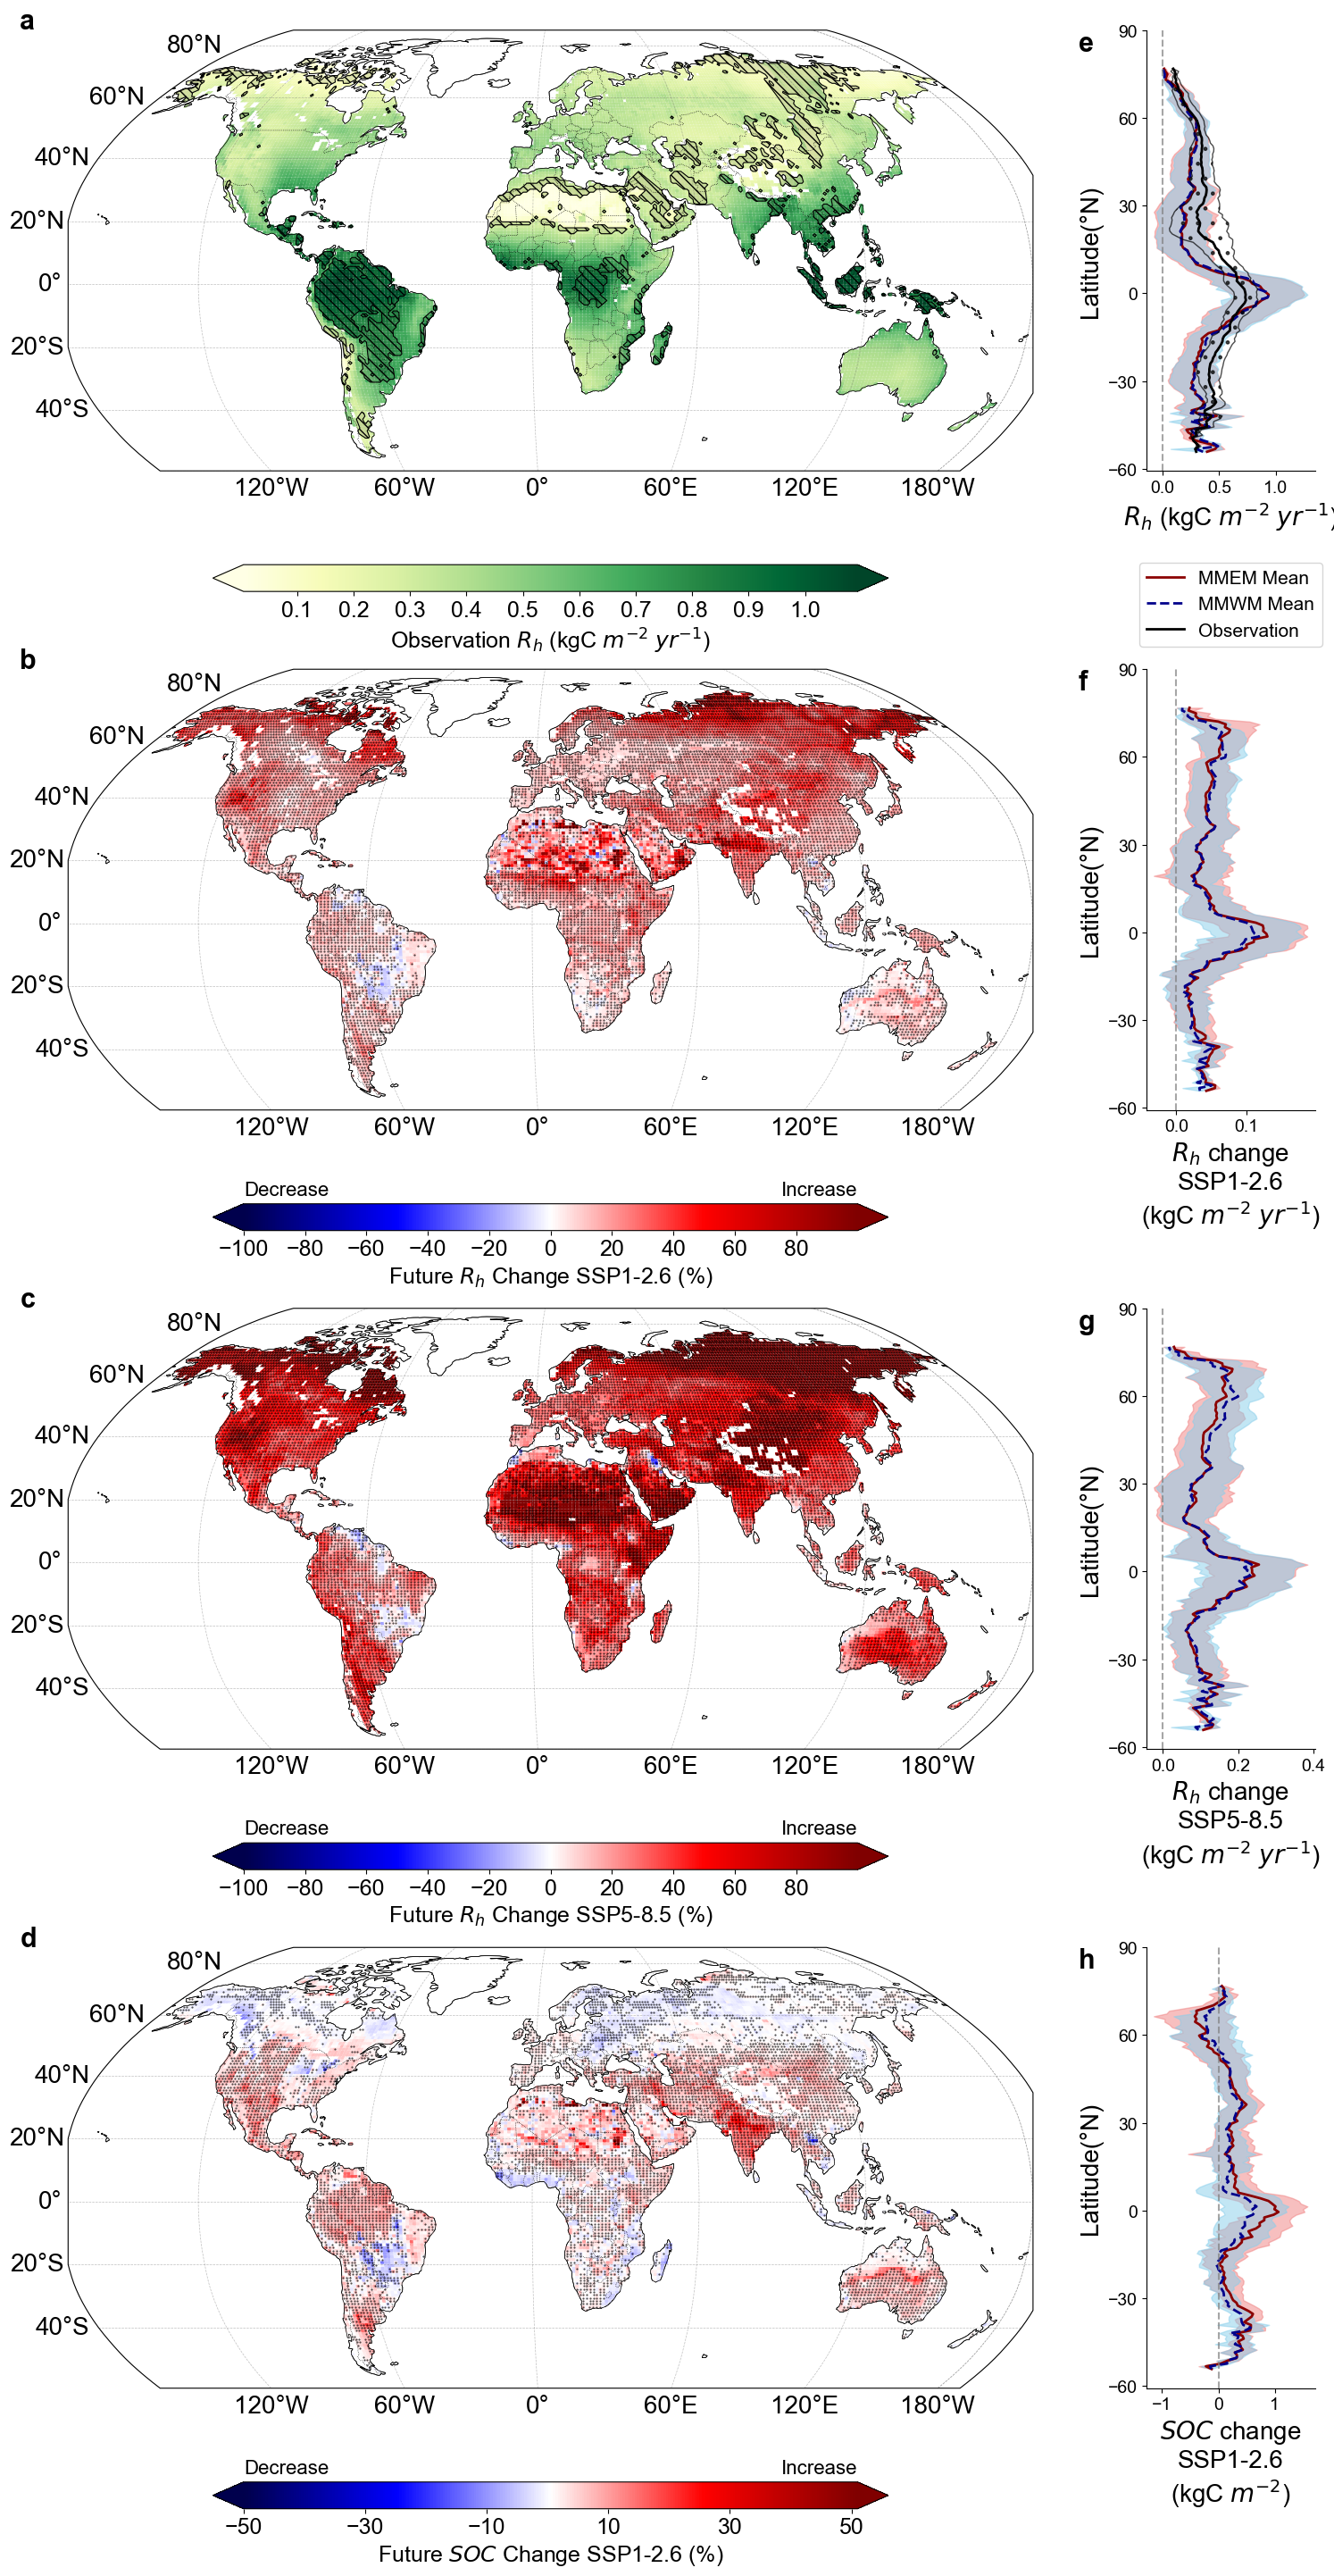

In [10]:
def create_extendedfigure2():
    # 重置matplotlib默认样式，避免全局设置干扰
    plt.rcParams.update(plt.rcParamsDefault)
    # 明确设置子图背景色和边框默认值
    plt.rcParams['axes.facecolor'] = 'white'       # 子图背景白色
    plt.rcParams['axes.edgecolor'] = 'black'       # 边框默认黑色
    plt.rcParams.update({
        'font.family': 'serif',           # 主字体类型（serif衬线 / sans-serif无衬线）
        'font.serif': ['Arial'], # 衬线字体首选
        'font.sans-serif': ['Times New Roman'],      # 无衬线字体备选
    })

    # 创建图形和子图布局
    fig = plt.figure(figsize=(16, 30))

    # 创建2x1的子图布局（根据实际需求调整）
    gs = gridspec.GridSpec(4, 2, width_ratios=[6, 1], figure=fig, wspace=0.15, hspace=0.45, top=0.95, bottom=0.07, left=0.1, right=0.99)
    # 第一个子图（图1a）
    ax1 = fig.add_subplot(gs[0], projection=ccrs.Robinson(central_longitude=10))
    mesh1 = plot_extendedfig2a(fig, ax1)

    # 第二个子图（图1e）
    ax2 = fig.add_subplot(gs[1])
    mesh2 = plot_extendedfig2e(fig, ax2)

    # 第三个子图（图1b）
    ax3 = fig.add_subplot(gs[2], projection=ccrs.Robinson(central_longitude=10))
    mesh3 = plot_extendedfig2b(fig, ax3)

    # 第四个子图（图1f）
    ax4 = fig.add_subplot(gs[3])
    mesh4 = plot_extendedfig2f(fig, ax4)

    # 第五个子图（图1c）
    ax5 = fig.add_subplot(gs[4], projection=ccrs.Robinson(central_longitude=10))
    mesh5 = plot_extendedfig2c(fig, ax5)

    # 第六个子图（图1g）
    ax6 = fig.add_subplot(gs[5])
    mesh6 = plot_extendedfig2g(fig, ax6)

    # 第七个子图（图1d）
    ax7 = fig.add_subplot(gs[6], projection=ccrs.Robinson(central_longitude=10))
    mesh7 = plot_extendedfig2d(fig, ax7)

    # 第八个子图（图1h）
    ax8 = fig.add_subplot(gs[7])
    mesh8 = plot_extendedfig2h(fig, ax8)

    plt.show()

if __name__ == '__main__':
    create_extendedfigure2()